# Airbnb data insight for Boston and Seattle area

##  Background

Airbnb is currently a very popular platform for both guests and hosts to enjoy their customized travellings. There are many interesting things we can explore using the data from Airbnb insight. Let's get started by using the data of Boston and Seattle cities.

Three interesting questions come to my mind when looking into the data:

1. Is there any difference in price between Boston and Seattle area?
2. Can we predict price in Boston and Seattle Airbnb using this dataset?
3. What's the top important features when predicting the price in two cities?

## Load the data first:

In [73]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import mplleaflet
from tqdm import tqdm
from xgboost import plot_importance
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from functools import reduce

In [2]:
boston_listings = pd.read_csv('../data/boston/listings.csv')
seattle_listings = pd.read_csv('../data/seattle/listings.csv')

In [3]:
boston_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.3


In [4]:
seattle_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


## Visualize airbnb location in Boston and Seattle area

Dataset from both Boston and Seattle contains geographical information. Let's draw their geospatial distribution in map to take a look.

In [5]:
boston_samples = boston_listings.sample(100)
plt.scatter(boston_samples['longitude'], boston_samples['latitude'])
mplleaflet.display()

In [6]:
seattle_samples = seattle_listings.sample(100)
plt.scatter(seattle_samples['longitude'], seattle_samples['latitude'])
mplleaflet.display()

As our expectation, most rents locate at downtown area, where travellers can find more fun :)). Let's try to solve the three questions above then.

## Is there any difference in price?

In [7]:
boston_prices = pd.read_csv('../data/boston/calendar.csv').dropna(how = 'any', axis = 0)
seattle_prices = pd.read_csv('../data/seattle/calendar.csv').dropna(how = 'any', axis = 0)

In [8]:
seattle_prices.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
9,241032,2016-01-13,t,$85.00
10,241032,2016-01-14,t,$85.00
14,241032,2016-01-18,t,$85.00


In [9]:
boston_prices['price'] = boston_prices['price'].apply(lambda x : float(x.replace('$', '').replace(',', '')))
seattle_prices['price'] = seattle_prices['price'].apply(lambda x : float(x.replace('$', '').replace(',', '')))

In [10]:
boston_prices['price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

In [11]:
seattle_prices['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

## Two distribution t-test with different variance assumption

$$H_0 : \bar{X_1}\ =\ \bar{X_2}  \\ H_1 : \bar{X_1}\ !=\ \bar{X_2}$$


$$t = \frac{\bar{X_1} - \bar{X_2}}{s}\enspace$$  satisfies t-distribution where 
$$\enspace s = \sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}$$


Degree of freedom is equal to
$$
DF = \frac{(VAR_1 + VAR_2)^2}{\frac{VAR_1^2}{n_1 - 1} + \frac{VAR_2^2}{n_2 - 1}} 
$$

After testing, we find that the p-value is smaller than 0.001, which means that we should reject $H_0$ with a high confidence. And the average renting price between Boston and Seattle is very different.

In [12]:
s_2 = np.sqrt(seattle_prices['price'].std()**2 / seattle_prices['price'].shape[0] + \
              boston_prices['price'].std()**2 / boston_prices['price'].shape[0])

t = (seattle_prices['price'].mean() - boston_prices['price'].mean()) / s_2

In [13]:
t

-242.40846787381446

In [14]:
seattle_prices['price'].var()

11038.206657946257

In [15]:
DF = (seattle_prices['price'].var() + boston_prices['price'].var())**2 / \
     (seattle_prices['price'].var()**2 / (seattle_prices['price'].shape[0] - 1) + \
      boston_prices['price'].var()**2 / (boston_prices['price'].shape[0] - 1))
DF

1069725.0833099699

According to the t-test table, we find that the mean value for prices in Boston and Seattle is different. With p-value < 0.001

## Price value histogram for Boston and Seattle cities

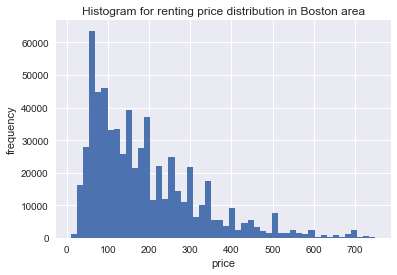

In [16]:
plt.hist(list(boston_prices[boston_prices['price'] < 5 * np.median(boston_prices['price'])]['price']), bins = 50)
#plt.hist(list(boston_prices[boston_prices['price'] < np.mean(boston_prices['price']) + \
#                                                     5 * np.std(boston_prices['price'])]['price']), bins = 50)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Histogram for renting price distribution in Boston area')
plt.show()

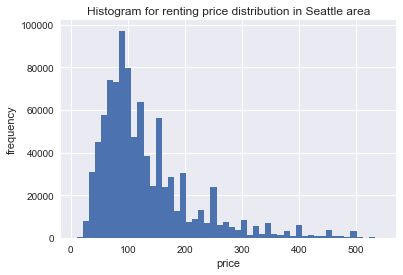

In [17]:
plt.hist(list(seattle_prices[seattle_prices['price'] < 5 * np.median(seattle_prices['price'])]['price']), bins = 50)
plt.xlabel('price')
plt.ylabel('frequency')
plt.title('Histogram for renting price distribution in Seattle area')
plt.show()

## Make prediction towards price in two cities

In [18]:
boston_prices = boston_prices.rename(columns = {'listing_id' : 'id'})
seattle_prices = seattle_prices.rename(columns = {'listing_id' : 'id'})

In [19]:
boston_df = pd.merge(boston_listings, boston_prices, on = 'id')
seattle_df = pd.merge(seattle_listings, seattle_prices, on = 'id')

In [81]:
boston_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

### data cleaning

In [132]:
boston_df['host_response_rate'] = boston_df['host_response_rate'].apply(lambda x : float(str(x).replace('%', '')) / 100)
boston_df['host_acceptance_rate'] = boston_df['host_acceptance_rate'].apply(lambda x : float(str(x).replace('%', '')) / 100)
boston_df['price_x'] = boston_df['price_x'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
boston_df['weekly_price'] = boston_df['weekly_price'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
boston_df['monthly_price'] = boston_df['monthly_price'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
boston_df['security_deposit'] = boston_df['security_deposit'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
boston_df['cleaning_fee'] = boston_df['cleaning_fee'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
boston_df['extra_people'] = boston_df['extra_people'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))

In [155]:
seattle_df['host_response_rate'] = seattle_df['host_response_rate'].apply(lambda x : float(str(x).replace('%', '')) / 100)
seattle_df['host_acceptance_rate'] = seattle_df['host_acceptance_rate'].apply(lambda x : float(str(x).replace('%', '')) / 100)
seattle_df['price_x'] = seattle_df['price_x'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
seattle_df['weekly_price'] = seattle_df['weekly_price'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
seattle_df['monthly_price'] = seattle_df['monthly_price'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
seattle_df['security_deposit'] = seattle_df['security_deposit'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
seattle_df['cleaning_fee'] = seattle_df['cleaning_fee'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))
seattle_df['extra_people'] = seattle_df['extra_people'].apply(lambda x : float(str(x).replace('$', '').replace(',', '')))

In [156]:
b_columns = [col for col in boston_df.columns if boston_df[col].dtype == 'float64' or boston_df[col].dtype == 'int64']
s_columns = [col for col in seattle_df.columns if seattle_df[col].dtype == 'float64' or seattle_df[col].dtype == 'int64']

In [157]:
boston_numeric = boston_df[b_columns]
seattle_numeric = seattle_df[s_columns]

In [158]:
boston_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'price_x', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'license',
       'jurisdiction_names', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

# Dealing with missing values

Categorical features are not used in this project. Some numerical features have missing values and a few of them have no valid values. We delete the features with all missing values. For the missing values of the rest features, we impute them with $\textbf{median}$ value. The reason we don't use mean to fill the missing part is to avoid disturbance caused by outliers.

### Drop features with all null value

In [22]:
seattle_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

In [23]:
boston_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'square_feet', 'guests_included', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month', 'price_y'],
      dtype='object')

In [159]:
boston_numeric = boston_numeric.drop(columns = boston_numeric.columns[boston_numeric.isnull().all()])
seattle_numeric = seattle_numeric.drop(columns = seattle_numeric.columns[seattle_numeric.isnull().all()])

In [137]:
boston_numeric.columns[boston_numeric.isnull().any()]

Index(['host_response_rate', 'host_acceptance_rate', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

### fill na with median of columns

In [160]:
fill_median = lambda col : col.fillna(col.median())
boston_numeric = boston_numeric.apply(fill_median, axis = 0)
seattle_numeric = seattle_numeric.apply(fill_median, axis = 0)

In [139]:
boston_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_response_rate',
       'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price_x',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value',
       'calculated_host_listings_count', 'reviews_per_month', 'price_y'],
      dtype='object')

In [140]:
seattle_numeric.columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'price_y'],
      dtype='object')

### Filter useless features

In [161]:
boston_numeric = boston_numeric.drop(columns=['scrape_id', 'host_id'])
seattle_numeric = seattle_numeric.drop(columns=['scrape_id', 'host_id'])

# price prediction with xgboost

In [142]:
def train_test_id(id_lst, test_portion = 0.3):
    """
        Randomly split training and test id.
        Input: 
            id_lst is the list of all ids
        return:
            train_id_list, test_id_list
    """
    id_set = set(id_lst)
    size = len(id_set)
    test_set = set()
    while True:
        if np.random.rand() <= 0.5:
            test_set.add(id_set.pop())
        if len(test_set) >= test_portion * size:
            break
    return id_set, test_set
    

In [143]:
def search_params(params, estimator, X, y, cv = 5):
    """
        Search optimal hyper-parameters for estimator.
    """
    clf = GridSearchCV(estimator, params, cv = cv, scoring = 'neg_mean_squared_error', verbose = 2)
    clf.fit(X, y)
    return clf.best_params_

def cal_rmse(y_pred, y_true):
    """
        calculate root mean square error based on predicted and true result.
    """
    return np.sqrt(np.sum((y_pred - y_true)**2 / len(y_pred)))
    

In [162]:
X_boston, y_boston = boston_numeric.loc[:,boston_numeric.columns != 'price_y'], boston_numeric['price_y']
X_seattle, y_seattle = seattle_numeric.loc[:,seattle_numeric.columns != 'price_y'], seattle_numeric['price_y']

## Boston price prediction:

In [33]:
def visualize_pred(y_pred, y_test, city = 'Boston'):
    """
        Visualize predicted result for 100 randomly selected samples
    """
    vis_lst = [i for i in range(len(y_pred))]
    np.random.shuffle(vis_lst)
    y_test = y_test.reset_index()

    fig, ax = plt.subplots(figsize=(10,8))
    ax.set(xlabel='Samples', ylabel='prices',
           title='Predicted and true price comparison for Airbnb in ' + city +' area(100 samples)')
    ax.plot(range(len(y_pred[vis_lst[:100]])),y_pred[vis_lst[:100]], color = 'blue')
    ax.plot(range(len(y_test.loc[vis_lst[:100], 'price_y'])),y_test.loc[vis_lst[:100], 'price_y'], color = 'red')
    ax.legend(('predicted price', 'true price'),
               loc='upper right')
    plt.show() 

In [145]:
train_id, test_id = train_test_id(boston_numeric['id'].unique())

#Generate training_entries and test_entries:
train_entries = list(tqdm(map(lambda x : x in train_id, boston_numeric['id'])))
test_entries = list(tqdm(map(lambda x : x in test_id, boston_numeric['id'])))

X_train, X_test, y_train, y_test = X_boston[train_entries], X_boston[test_entries], \
                                   y_boston[train_entries], y_boston[test_entries]


0it [00:00, ?it/s]
88983it [00:00, 889828.73it/s]
179671it [00:00, 894873.50it/s]
279006it [00:00, 922298.82it/s]
391062it [00:00, 973997.41it/s]
501856it [00:00, 1010649.36it/s]
622732it [00:00, 1062910.96it/s]
643037it [00:00, 1012047.59it/s]
0it [00:00, ?it/s]
97941it [00:00, 979408.60it/s]
196119it [00:00, 980116.30it/s]
305679it [00:00, 1012121.25it/s]
419605it [00:00, 1047177.63it/s]
544716it [00:00, 1101017.36it/s]
643037it [00:00, 1101658.58it/s]

In [339]:
#Parameters search for xgBoost. Heavy time consumption.
params = {'max_depth' : [5, 7, 10],
          'learning_rate' : [0.05, 0.1],
          'n_estimators' : [200]}

xgb = XGBRegressor(booster='gbtree', n_jobs=2)
boston_opt_params = search_params(params, xgb, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  57.8s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.5s remaining:    0.0s


[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  59.9s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  58.9s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  57.9s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total=  57.7s
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=7, total= 1.4min
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=7, total= 1.4min
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=7, total= 1.4min
[CV] learning_rate=0.1, n_estimators=200, max_depth=7 ................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 22.4min finished


In [149]:
xgb_boston = XGBRegressor(booster='gbtree', **boston_opt_params)
xgb_boston.fit(X_train, y_train, eval_metric = 'rmse')
y_pred = xgb_boston.predict(X_test)

In [150]:
print(cal_rmse(y_pred, y_test))

71.71732526948233


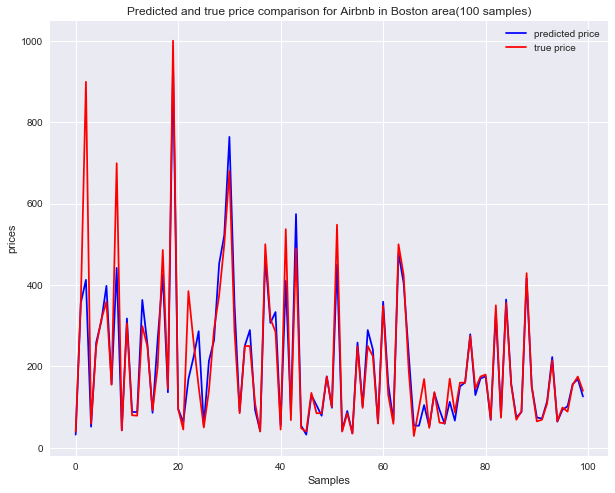

In [154]:
visualize_pred(y_pred, y_test)

## Seattle price prediction:

In [163]:
train_id, test_id = train_test_id(seattle_numeric['id'].unique())

#Generate training_entries and test_entries:
train_entries = list(tqdm(map(lambda x : x in train_id, seattle_numeric['id'])))
test_entries = list(tqdm(map(lambda x : x in test_id, seattle_numeric['id'])))

X_train, X_test, y_train, y_test = X_seattle[train_entries], X_seattle[test_entries], \
                                   y_seattle[train_entries], y_seattle[test_entries]


0it [00:00, ?it/s]
87842it [00:00, 878410.37it/s]
180357it [00:00, 891926.53it/s]
278278it [00:00, 916432.48it/s]
380318it [00:00, 945322.65it/s]
489992it [00:00, 986165.86it/s]
605070it [00:00, 1030377.76it/s]
719417it [00:00, 1061882.20it/s]
837117it [00:00, 1093981.19it/s]
934542it [00:00, 1044213.57it/s]
0it [00:00, ?it/s]
93998it [00:00, 939969.69it/s]
191012it [00:00, 948819.50it/s]
297456it [00:00, 980779.08it/s]
406168it [00:00, 1010428.44it/s]
512364it [00:00, 1025354.61it/s]
629363it [00:00, 1064843.32it/s]
748960it [00:00, 1101044.58it/s]
874496it [00:00, 1143199.71it/s]
934542it [00:00, 1092515.17it/s]

In [199]:
params = {'booster' : ['gbtree'],
          'max_depth' : [5, 7, 10],
          'learning_rate' : [0.1],
          'n_estimators' : [200]}

xgb = XGBRegressor()
seattle_opt_params = search_params(params, xgb, X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  54.0s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.7s remaining:    0.0s


[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  54.5s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  55.3s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  52.3s
[CV] learning_rate=0.1, n_estimators=100, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=100, max_depth=5, total=  52.2s
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total= 1.8min
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total= 1.7min
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] . learning_rate=0.1, n_estimators=200, max_depth=5, total= 1.7min
[CV] learning_rate=0.1, n_estimators=200, max_depth=5 ................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 13.4min finished


In [166]:
seattle_opt_params = {'booster' : 'gbtree', 'max_depth' : 7, 'learning_rate' : 0.1, 'n_estimator' : 200}
xgb_seattle = XGBRegressor(**seattle_opt_params)
xgb_seattle.fit(X_train, y_train, eval_metric = 'rmse')
y_pred_seattle = xgb_seattle.predict(X_test)
print(cal_rmse(y_pred_seattle, y_test))

41.152820510810656


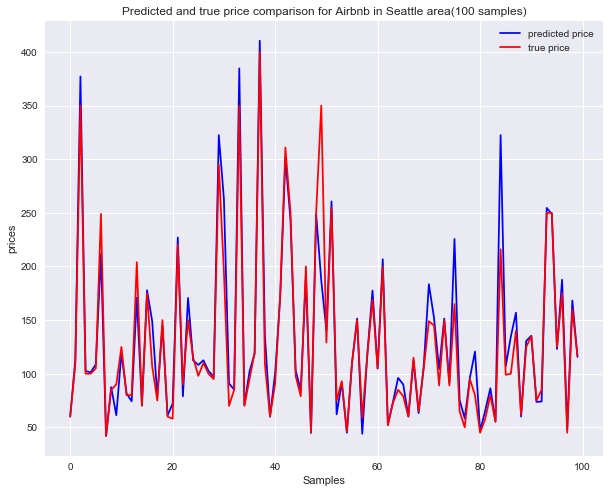

In [167]:
visualize_pred(y_pred_seattle, y_test, 'Seattle')

# Top important features for price prediction

In [223]:
def visualize_feature(features, feat_importance, city = 'Boston'):
    """
        Visualize important features for predicting renting prices
    """
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set(xlabel='feature name', ylabel='feature importance',
           title='feature importance level for ' + city + ' city')
    ax.bar(features, feat_importance)
    plt.xticks(features, rotation='vertical')
    plt.show() 

### Boston city

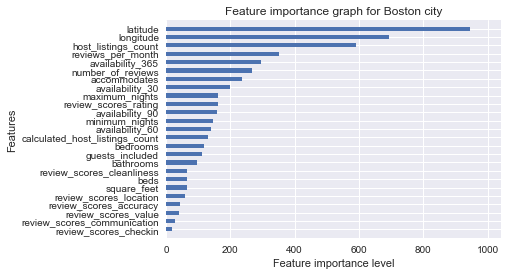

In [234]:
plot_importance(xgb_boston, height=0.5, show_values=False, xlabel='Feature importance level', \
                title='Feature importance graph for Boston city')
plt.show()

### Seattle city

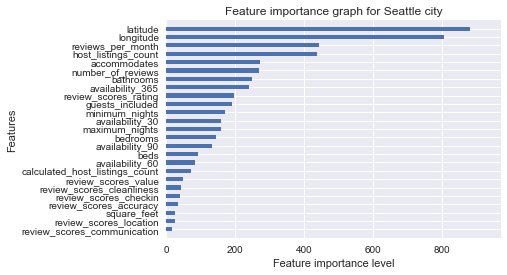

In [239]:
plot_importance(xgb_seattle, height=0.5, show_values=False, xlabel='Feature importance level', \
                title='Feature importance graph for Seattle city')
plt.show()

# Fit model with all features

In [34]:
boston_df = pd.merge(boston_listings, boston_prices, on = 'id')
seattle_df = pd.merge(seattle_listings, seattle_prices, on = 'id')

## Boston model:

In [56]:
def create_dummy_df(df, cat_cols, dummy_na):
    for col in tqdm(cat_cols):
        df = pd.concat([df.drop(col, axis = 1), \
                        pd.get_dummies(df[col], prefix = col, \
                                     prefix_sep = '_', drop_first = True, dummy_na = dummy_na)], axis = 1)
    return df

In [65]:
cat_boston = boston_df.select_dtypes(include=['object'])
cat_boston.head(2)

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,date,available
0,https://www.airbnb.com/rooms/3075044,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,...,2016-09-06,2014-06-01,2016-08-13,f,t,moderate,f,f,2017-08-22,t
1,https://www.airbnb.com/rooms/3075044,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Plenty of safe street parking. Bus stops a few...,...,2016-09-06,2014-06-01,2016-08-13,f,t,moderate,f,f,2017-08-21,t


In [79]:
cat_boston = cat_boston.drop([col for col in cat_boston.columns if len(cat_boston[col].unique()) > 10], axis = 1)
#cat_boston.head(2)

In [58]:
boston_new = create_dummy_df(boston_df, cat_boston.columns, dummy_na=True)
boston_new.head(2)

  3%|▎         | 2/64 [00:44<27:00, 26.14s/it]

KeyboardInterrupt: 